# Autoencoder on MNIST
In this tutorial, we implement an **Autoencoder** using PyTorch.  
Unlike classifiers (MLP, CNN), an autoencoder’s goal is **not** to predict labels, but to **learn a compressed representation** of input data and then reconstruct it.

In this tutorial, we implement an **Autoencoder** using PyTorch.  
Unlike classifiers (MLP, CNN), an autoencoder’s goal is **not** to predict labels, but to **learn a compressed representation** of input data and then reconstruct it.

##### What is an Autoencoder?

An **Autoencoder** is a neural network trained to reconstruct its own input.  
It consists of two main parts:

- **Encoder**: Maps the input (e.g., a 28×28 image) into a lower-dimensional latent space (also called a *bottleneck*).
- **Decoder**: Reconstructs the input from this compressed latent representation.

The network learns by minimizing the difference between the input and the reconstructed output.

##### Why Autoencoders?

Autoencoders are useful for:
- **Dimensionality reduction** (like a non-linear PCA).
- **Feature learning**: The latent space often captures meaningful patterns in the data.
- **Anomaly detection**: Unseen or unusual samples are poorly reconstructed.
- **Pretraining**: Learned representations can help in downstream tasks.

##### Architecture in This Notebook

For **MNIST handwritten digits (28×28 grayscale)**:
1. **Encoder**:  
   - Input: 784 (28×28 flattened pixels)  
   - Hidden layer: 128 units (ReLU)  
   - Bottleneck: 32 units (latent vector)
2. **Decoder**:  
   - Expands from latent vector → hidden layer → reconstructs 784 pixels  
   - Output reshaped back to 28×28  
   - Final activation: Sigmoid (values between 0–1)

##### Training Objective

- **Loss Function**: Mean Squared Error (MSE) between original and reconstructed images.  
- **Optimizer**: Adam.  

The network tries to minimize reconstruction error so that the decoded images look as close as possible to the input digits.

##### Steps in This Notebook

1. **Load MNIST dataset**.  
2. **Define the Autoencoder model** with encoder + decoder.  
3. **Train the model** using reconstruction loss.  
4. **Evaluate reconstruction quality** on test data.  
5. **Visualize original vs reconstructed digits**.

# Code

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Data Load

In [2]:
def get_mnist_dataloaders(batch_size=64, root="../../data", shuffle_test=False):
    # simple transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    train_dataset = datasets.MNIST(root, train=True, download=True, transform=transform)
    test_dataset  = datasets.MNIST(root, train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_test)
    return train_loader, test_loader

### Autoencoder Architecture

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128, bottleneck_size=28):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, bottleneck_size),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()   # outputs between 0–1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)      # flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)  # reshape back to image
        return decoded


In [4]:
def reconstruction_loss(outputs, inputs):
    return torch.mean((outputs - inputs) ** 2)

### Training

In [5]:
def train(epochs=5, batch_size=128, lr=1e-3, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    train_loader, test_loader = get_mnist_dataloaders(batch_size=batch_size)
    model = Autoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:  # ignore labels
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss={avg_loss:.4f}")

        # evaluate reconstruction on test set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item()
        test_loss /= len(test_loader)
        print(f" → Test Loss={test_loss:.4f}")

    torch.save(model.state_dict(), "autoencoder.pth")
    print("Model saved to autoencoder.pth")

    return model


In [6]:
model = train(epochs=10, batch_size=128, lr=1e-3)

Using device: cpu
Epoch 1: Train Loss=0.6643
 → Test Loss=0.5932
Epoch 2: Train Loss=0.5721
 → Test Loss=0.5656
Epoch 3: Train Loss=0.5553
 → Test Loss=0.5552
Epoch 4: Train Loss=0.5466
 → Test Loss=0.5487
Epoch 5: Train Loss=0.5410
 → Test Loss=0.5444
Epoch 6: Train Loss=0.5376
 → Test Loss=0.5419
Epoch 7: Train Loss=0.5351
 → Test Loss=0.5398
Epoch 8: Train Loss=0.5330
 → Test Loss=0.5379
Epoch 9: Train Loss=0.5310
 → Test Loss=0.5358
Epoch 10: Train Loss=0.5293
 → Test Loss=0.5348
Model saved to autoencoder.pth


### Test and View Predictions

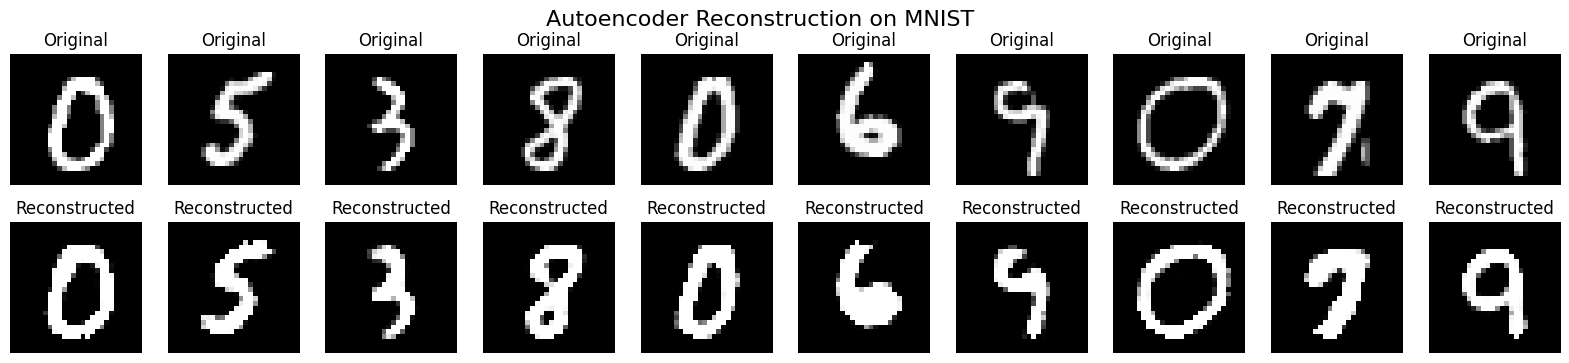

In [7]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder()
model.load_state_dict(torch.load("autoencoder.pth", map_location=device))
model.to(device)
model.eval()

# Load test data
_, test_loader = get_mnist_dataloaders(batch_size=10, shuffle_test=True)
images, _ = next(iter(test_loader))
images = images.to(device)

# Get reconstructions
with torch.no_grad():
    outputs = model(images)

# Convert back to CPU numpy
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# Plot originals vs reconstructions
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("Autoencoder Reconstruction on MNIST", fontsize=16)
plt.show()